<a href="https://colab.research.google.com/github/AnnaBujniewicz/Masters_thesis/blob/main/5_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Initial steps

In [ ]:
# LOWERCASE TICKER
ticker = "zm"

In [ ]:
# importing  packages
!pip install transformers &> /dev/null
!pip install yfinance &> /dev/null
!pip install bert-for-tf2 &> /dev/null
import bert
import os
import tensorflow_hub as hub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
import gensim
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from datetime import datetime
nltk.download('wordnet')
warnings.filterwarnings('ignore')
from collections import Counter
import itertools
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from keras import backend as K
from transformers import BertTokenizer
import torch
import re
import tensorflow as tf
import yfinance as yf
from sklearn.metrics import r2_score
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib  &> /dev/null
import talib
! pip install ta  &> /dev/null
import ta
from ta import add_all_ta_features
from ta.utils import dropna
from talib import abstract
from google.colab import files

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Selecting previously unselected package libta-lib0.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [ ]:
# importing data
#titles = pd.read_csv("/content/proc_{}_data.csv".format(ticker))
tech = yf.download(ticker.upper(), 
                      start='2020-12-01', 
                      end='2021-01-31',
                      interval = "1h")

[*********************100%***********************]  1 of 1 completed


In [ ]:
tech

,Open,High,Low,Close,Adj Close,Volume
2020-12-01 09:30:00-05:00,428.000000,428.006012,411.540009,416.779999,416.779999,8475624
2020-12-01 10:30:00-05:00,416.914093,417.032013,410.220093,414.519989,414.519989,3127455
2020-12-01 11:30:00-05:00,414.510010,414.510010,411.579987,411.809998,411.809998,1699863
2020-12-01 12:30:00-05:00,412.000000,413.790009,405.339996,408.489990,408.489990,2289552
2020-12-01 13:30:00-05:00,408.589996,408.859985,406.000000,406.900085,406.900085,1363444
...,...,...,...,...,...,...
2021-01-29 11:30:00-05:00,368.190002,371.369995,363.799988,364.024994,364.024994,559182
2021-01-29 12:30:00-05:00,363.800293,364.380005,358.620087,363.299011,363.299011,644995
2021-01-29 13:30:00-05:00,363.130005,366.359985,361.302490,365.149994,365.149994,368226
2021-01-29 14:30:00-05:00,365.279999,371.899994,364.190002,368.856110,368.856110,419947


# 1. Preparing the data

## 1.1. Prices data preparation

In [ ]:
# selecting and normalizing the closing hourly price
prices = pd.DataFrame(tech.iloc[:,3])
scaler = MinMaxScaler(feature_range=(0, 1))
prices.iloc[:,0] = scaler.fit_transform(prices.iloc[:,0].values.reshape(-1,1))

In [ ]:
# changing the index to fit  with  datetime format
prices.index = prices.index.map(lambda x: x.astype(str))
prices.index = prices.index.map(lambda x: x[:19])

## 1.2. Pre-processing the text

In [ ]:
# cleanup and  sorting
titles["datetime"] = titles["date"]  + " "  + titles["time"]
titles.set_index("datetime", inplace = True)
titles = titles.drop(["Unnamed: 0", "date", "time", "link"], axis = 1)
titles.sort_index(ascending = True, inplace=True)

In [ ]:
# adjusting timezones
titles.index = pd.DatetimeIndex(titles.index)
prices.index = pd.DatetimeIndex(prices.index)
titles.index = titles.index.tz_localize('Europe/Brussels').tz_convert('UTC')

In [ ]:
# unix timestamp for filtering
titles.index = titles.index.astype(np.int64)
prices.index = prices.index.astype(np.int64)

In [ ]:
# settin up news index for every hour
new_index = []
for x in titles.index:
  new_index.append(prices.index[prices.index > x].min()) 

In [ ]:
# applying the new timestamp and reverting to datetime
titles.index  = new_index
titles.index = pd.DatetimeIndex(titles.index)
titles = titles.loc[titles.index.notnull()]
prices.index = pd.DatetimeIndex(prices.index)

In [ ]:
# filtering out the timestamps before the first article
prices = prices.loc[prices.index >= titles.index[0]]

In [ ]:
# creating a dictionary with dates and all respective titles
titles_concat = {"date":[], "titles":[]}
for date in titles.index:
  titles_concat["titles"].append(" ".join(titles[titles.index==date]["title"]))
  titles_concat["date"].append(date)

In [ ]:
#  fixing the index,  dropping duplicates
titles_concat  = pd.DataFrame(titles_concat)
titles_concat  = titles_concat.set_index("date")
titles_concat.index = pd.DatetimeIndex(titles_concat.index)
titles_concat =  titles_concat.drop_duplicates(subset="titles")

In [ ]:
# matching the index and forward filling
prices["titles"] = titles_concat["titles"]
prices["titles"] = prices["titles"].ffill()

In [ ]:
# initiating a lemmatizer instance
lemmatizer = WordNetLemmatizer()
# making a list of stopwords
stop_words = set(stopwords.words('english'))
# making a function that lemmatizes the titles and then puts them together
def sneaky_cleanup(title):
  tokens = []
  for token in title.split():
    if token not in stop_words:
      if token.isalnum():
        tokens.append(lemmatizer.lemmatize(token))
  return " ".join(tokens)
prices.titles = prices.titles.apply(lambda x: sneaky_cleanup(x))

In [ ]:
# moving the data  1 h  forward to match the target
prices["titles"] = prices["titles"].shift(1)

In [ ]:
# split into  train and  test  sample and format change
train_label = prices.loc[prices.index[1]:"2021-01-19 09:30:00", "Close"]
test_label = prices.loc["2021-01-19 09:30:00":, "Close"]
train_titles = prices.loc[prices.index[1]:"2021-01-19 09:30:00", "titles"]
test_titles = prices.loc["2021-01-19 09:30:00":, "titles"]
train_titles.index = train_titles.index.astype(np.int64)
test_titles.index = test_titles.index.astype(np.int64)

## 1.3. Transformer-specific pre-processing

In [ ]:
# initiating a bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# using a slightly modified pre-made function that partially processes the data for bert
# the function runs on torch, not tensorflow, so the outputs will need to be turned into numpy arrays
def preprocessing_for_bert(data):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Specifying MAX_LEN based on the previuously inspected title length
MAX_LEN = 300

# Run function preprocessing_for_bert on the train set and the test set
train_inputs, train_masks = preprocessing_for_bert(train_titles)
val_inputs, val_masks = preprocessing_for_bert(test_titles)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# creating id columns based on the index
train_ids = torch.tensor(train_titles.index.tolist())
test_ids = torch.tensor(test_titles.index.tolist())

In [ ]:
# turning the torch tensors into numpy arrays of the required type
train_inputs = train_inputs.numpy().astype("int32")
train_masks = train_masks.numpy().astype("int32")
train_ids = train_ids.numpy().astype("int32")
val_inputs = val_inputs.numpy().astype("int32")
val_masks = val_masks.numpy().astype("int32")
test_ids = test_ids.numpy().astype("int32")

In [ ]:
# putting the id, mask and tensor in a dictionary
X_train_dic = {"input_word_ids":train_inputs,"input_mask":train_masks,"input_type_ids":train_ids}
X_test_dic = {"input_word_ids":val_inputs,"input_mask":val_masks,"input_type_ids":test_ids}

## 1.4. Creating the technical predictors

In [ ]:
# dropping this price - it breaks the functions
tech  = tech.drop(["Adj Close"],axis=1)
# adding all the  technical indicators
tech = ta.add_all_ta_features(
    tech, "Open", "High", "Low", "Close", "Volume", fillna=True
)
tech.columns = tech.columns.str.lower()
tech['CDLENGULFING'] = abstract.CDLENGULFING(tech)
tech['CDLSHORTLINE'] = abstract.CDLSHORTLINE(tech)

In [ ]:
# only keeping  the indicators selected through  lasso
tech = tech.loc[:,['open', 'high', 'low', 'close', 'CDLENGULFING', 'CDLSHORTLINE',
       'volume_obv', 'volume_nvi', 'volatility_kchi', 'volatility_dch',
       'trend_sma_fast', 'trend_ichimoku_base', 'trend_aroon_up',
       'momentum_tsi', 'momentum_stoch']]

In [ ]:
# changing the index to follow datatime format
tech.index = tech.index.map(lambda x: x.astype(str))
tech.index = tech.index.map(lambda x: x[:19])
# normalizing
scaler_2 = MinMaxScaler(feature_range=(0, 1))
tech  = pd.DataFrame(scaler_2.fit_transform(tech), columns=tech.columns, index=tech.index)
# shifting to match the lag
tech = tech.shift(1)
# changng the index to   datetime
tech.index = pd.DatetimeIndex(tech.index)

In [ ]:
for col in tech.columns:
  prices[col] = tech[col]

In [ ]:
#split into train and test
train_tech = prices.loc[prices.index[1]:"2021-01-19 09:30:00", ['open', 'high', 'low', 'close', 'CDLENGULFING', 'CDLSHORTLINE',
       'volume_obv', 'volume_nvi', 'volatility_kchi', 'volatility_dch',
       'trend_sma_fast', 'trend_ichimoku_base', 'trend_aroon_up',
       'momentum_tsi', 'momentum_stoch']]
test_tech = prices.loc["2021-01-19 09:30:00":, ['open', 'high', 'low', 'close', 'CDLENGULFING', 'CDLSHORTLINE',
       'volume_obv', 'volume_nvi', 'volatility_kchi', 'volatility_dch',
       'trend_sma_fast', 'trend_ichimoku_base', 'trend_aroon_up',
       'momentum_tsi', 'momentum_stoch']]

In [ ]:
# reshaping the data appropriately
train_tech = train_tech.values.reshape(-1,15)
test_tech = test_tech.values.reshape(-1,15)
train_tech = np.reshape(train_tech, (train_tech.shape[0],1,train_tech.shape[1]))
test_tech = np.reshape(test_tech, (test_tech.shape[0],1,test_tech.shape[1]))

# 2. Training  the models

## 2.1. Model with text

In [ ]:
# importing bert for tf2
bert_v2 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=True, output_key="pooled_output")

INFO:absl:Using /tmp/tfhub_modules to cache modules.


In [ ]:
# creating a model
model = Sequential()
model.add(bert_v2)
model.add(layers.Dense(128))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(1))

In [ ]:
# the same learning rate as for the first model - again caused by stability issues
opt = optimizers.Adam(learning_rate=0.00001)

In [ ]:
# compiling the model
model.compile(loss='mean_squared_error', optimizer=opt)

In [ ]:
# fitting the model to the data
history = model.fit(X_train_dic, train_label, epochs=30, batch_size=8, verbose=1)

Epoch 1/30
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


28/28 [==============================] - 27s 499ms/step - loss: 0.5301
Epoch 2/30
28/28 [==============================] - 14s 503ms/step - loss: 0.1516
Epoch 3/30
28/28 [==============================] - 14s 507ms/step - loss: 0.1230
Epoch 4/30
28/28 [==============================] - 14s 511ms/step - loss: 0.0830
Epoch 5/30
28/28 [==============================] - 14s 514ms/step - loss: 0.1017
Epoch 6/30
28/28 [==============================] - 15s 519ms/step - loss: 0.0744
Epoch 7/30
28/28 [==============================] - 15s 522ms/step - loss: 0.0805
Epoch 8/30
28/28 [==============================] - 15s 525ms/step - loss: 0.0623
Epoch 9/30
28/28 [==============================] - 15s 527ms/step - loss: 0.0489
Epoch 10/30
28/28 [==============================] - 15s 529ms/step - loss: 0.0526
Epoch 11/30
28/28 [==============================] - 15s 532ms/step - loss: 0.0404
Epoch 12/30
28/28 [==============================] - 15s 534ms/step - loss: 0.0319
Epoch 13/30
28/28 [=====

In [ ]:
# predicting the data
predicted_label_text = model.predict(X_test_dic)

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


In [ ]:
predictions =  pd.DataFrame()
predictions["label"]  = test_label

In [ ]:
# filling a column with missing values and the predictions
predictions["text"] = np.nan
predictions["text"] = np.array(predicted_label_text).squeeze(1)

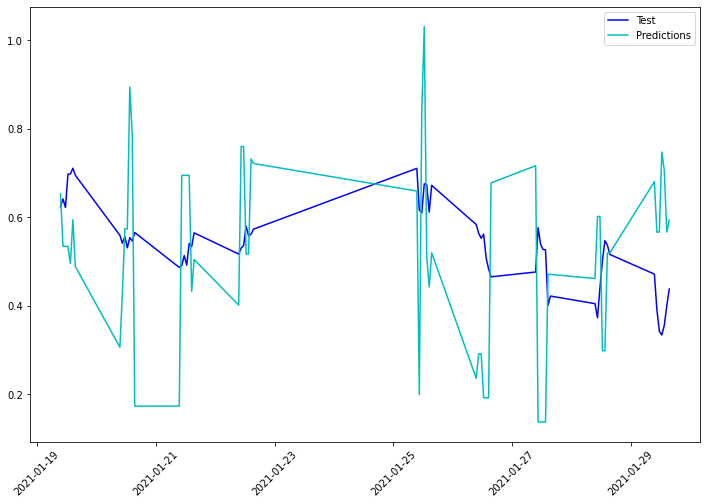

In [ ]:
# plotting the predictions against the test data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
plt.plot(test_label, color = "b")
plt.plot(predictions["text"], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.savefig('{}_text_plot.png'.format(ticker))
plt.show()

In [ ]:
# checking the mean squared error
RMSE_text = np.sqrt(np.mean(predictions["text"] - test_label)**2)
RMSE_text

0.02780005516484899

In [ ]:
# checking R-squared
R2_text  = r2_score(test_label, predictions["text"])
R2_text

-5.543202689228577

In [ ]:
# checking accuracy
accuraccy_check = pd.DataFrame()
accuraccy_check["label"] = test_label.diff()
accuraccy_check["text"] = predictions["text"].diff()
def assign_sign(row):    
  if row > 0:
      row = 1
  elif row < 0:
      row = -1
  else:
    row = 0
  return row
accuraccy_check["label"] = accuraccy_check["label"].apply(lambda x: assign_sign(x))
accuraccy_check["text"] = accuraccy_check["text"].apply(lambda x: assign_sign(x))
accuraccy_check["text_accuracy"] = np.where(accuraccy_check['label'] == accuraccy_check["text"], True, False)
acc_text = accuraccy_check[accuraccy_check["text"]!=0].text_accuracy.value_counts(normalize=True)[1]*100
acc_text

52.38095238095239

## 2.2. Model with technical indicators

In [ ]:
# creating a model
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape = (1,1,15))))
model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(layers.Dense(128))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(1))

In [ ]:
# the same learning rate as for the first model - again caused by stability issues
opt = optimizers.Adam(learning_rate=0.00001)

In [ ]:
# compiling the model
model.compile(loss='mean_squared_error', optimizer=opt)

In [ ]:
# fitting the model to the data
history = model.fit(train_tech, train_label, epochs=30, batch_size=16, verbose=1)

Epoch 1/30
14/14 [==============================] - 13s 35ms/step - loss: 0.3957
Epoch 2/30
14/14 [==============================] - 0s 31ms/step - loss: 0.4125
Epoch 3/30
14/14 [==============================] - 0s 30ms/step - loss: 0.3739
Epoch 4/30
14/14 [==============================] - 0s 32ms/step - loss: 0.3833
Epoch 5/30
14/14 [==============================] - 0s 31ms/step - loss: 0.3712
Epoch 6/30
14/14 [==============================] - 0s 33ms/step - loss: 0.3698
Epoch 7/30
14/14 [==============================] - 0s 31ms/step - loss: 0.3568
Epoch 8/30
14/14 [==============================] - 0s 33ms/step - loss: 0.3600
Epoch 9/30
14/14 [==============================] - 0s 31ms/step - loss: 0.3550
Epoch 10/30
14/14 [==============================] - 0s 32ms/step - loss: 0.3499
Epoch 11/30
14/14 [==============================] - 0s 31ms/step - loss: 0.3355
Epoch 12/30
14/14 [==============================] - 0s 33ms/step - loss: 0.3432
Epoch 13/30
14/14 [=================

In [ ]:
# predicting the data
predicted_label_tech = model.predict(test_tech)

In [ ]:
# filling a column with missing values and the predictions
predictions["tech"] = np.nan
predictions["tech"] = np.array(predicted_label_tech).squeeze(1)

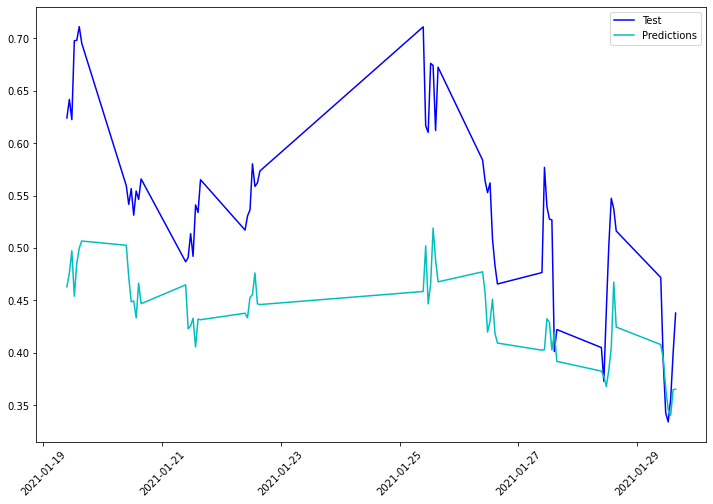

In [ ]:
# plotting the predictions against the test data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
plt.plot(test_label, color = "b")
plt.plot(predictions["tech"], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.savefig('{}_tech_plot.png'.format(ticker))
plt.show()

In [ ]:
# checking the mean squared error
RMSE_tech=np.sqrt(np.mean(predictions["tech"] - test_label)**2)
RMSE_tech

0.10149702066437875

In [ ]:
# checking R-squared
R2_tech = r2_score(test_label, predictions["tech"])
R2_tech

-0.7012502464410906

In [ ]:
# checking accuracy
accuraccy_check["tech"] = predictions["tech"].diff()
accuraccy_check["tech"] = accuraccy_check["tech"].apply(lambda x: assign_sign(x))
accuraccy_check["tech_accuracy"] = np.where(accuraccy_check['label'] == accuraccy_check["tech"], True, False)
acc_tech = accuraccy_check[accuraccy_check["tech"]!=0].tech_accuracy.value_counts(normalize=True)[1]*100
acc_tech

50.0

## 2.3. Model with technical indicators and test

In [ ]:
# creating the technical indicators  part of the model
tech_input = keras.Input(shape=(1,15))
tech_features = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(tech_input)
tech_features = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(tech_features)
tech_features = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(tech_features)

In [ ]:
# creating the  text handling part of the model
text_input = dict(
    input_word_ids=tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32),
    input_mask=tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32),
    input_type_ids=tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32),
)
text_features = bert_v2(text_input)

In [ ]:
# combining them and adding a joint part of the model
x = layers.concatenate([tech_features, text_features])
x = layers.Reshape((1,896))(x)
x = layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(x)
x = layers.LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(x)
x = layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
pred = layers.Dense(1)(x)

In [ ]:
model = keras.Model(
    inputs=[tech_input, text_input],
    outputs=[pred],)

In [ ]:
# the same learning rate as for the first model - again caused by stability issues
opt = optimizers.Adam(learning_rate=0.00001)

In [ ]:
# compiling the model
model.compile(loss='mean_squared_error', optimizer=opt)

In [ ]:
# fitting the model to the data
history = model.fit([train_tech,X_train_dic], [train_label], epochs=30, batch_size=8, verbose=1)

Epoch 1/30


28/28 [==============================] - 39s 541ms/step - loss: 0.3853
Epoch 2/30
28/28 [==============================] - 15s 541ms/step - loss: 0.3913
Epoch 3/30
28/28 [==============================] - 15s 541ms/step - loss: 0.3617
Epoch 4/30
28/28 [==============================] - 15s 545ms/step - loss: 0.3359
Epoch 5/30
28/28 [==============================] - 15s 547ms/step - loss: 0.3266
Epoch 6/30
28/28 [==============================] - 15s 548ms/step - loss: 0.2438
Epoch 7/30
28/28 [==============================] - 15s 546ms/step - loss: 0.1950
Epoch 8/30
28/28 [==============================] - 15s 547ms/step - loss: 0.1569
Epoch 9/30
28/28 [==============================] - 15s 545ms/step - loss: 0.1362
Epoch 10/30
28/28 [==============================] - 15s 546ms/step - loss: 0.1079
Epoch 11/30
28/28 [==============================] - 15s 547ms/step - loss: 0.0816
Epoch 12/30
28/28 [==============================] - 15s 546ms/step - loss: 0.0860
Epoch 13/30
28/28 [=====

In [ ]:
# predicting the data
predicted_label_both = model.predict([test_tech,X_test_dic])

In [ ]:
# filling a column with missing values and the predictions
predictions["both"] = np.nan
predictions["both"] = np.array(predicted_label_both).squeeze(1)

In [ ]:
# plotting the predictions against the test data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
plt.plot(test_label, color = "b")
plt.plot(predictions["both"], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.savefig('{}_both_plot.png'.format(ticker))
plt.show()

In [ ]:
# checking the mean squared error
RMSE_both = np.sqrt(np.mean(predictions["both"] - test_label)**2)
RMSE_both

In [ ]:
# checking R-squared
R2_both = r2_score(test_label, predictions["both"])
R2_both

In [ ]:
# checking accuracy
accuraccy_check["both"] = predictions["both"].diff()
accuraccy_check["both"] = accuraccy_check["both"].apply(lambda x: assign_sign(x))
accuraccy_check["both_accuracy"] = np.where(accuraccy_check['label'] == accuraccy_check["both"], True, False)
acc_both  = accuraccy_check[accuraccy_check["both"]!=0].both_accuracy.value_counts(normalize=True)[1]*100
acc_both

# 3. Preparing  and saving the results

In [ ]:
# reversing the scaling and saving the predictions
predictions = pd.DataFrame(scaler.inverse_transform(predictions),columns=predictions.columns, index=predictions.index)
predictions.to_csv("{}_predictions.csv".format(ticker))

In [ ]:
# df with the company name as a column and RMSE, R-squared and dir accuracy as rows
ratios = pd.DataFrame(data=[RMSE_text, RMSE_tech, RMSE_both,R2_text, R2_tech, R2_both,acc_text, acc_tech, acc_both],
                      columns=["{}".format(ticker)], index=["RMSE_text", "RMSE_tech", "RMSE_both","R2_text", "R2_tech", "R2_both","acc_text", "acc_tech", "acc_both"])
ratios.to_csv("{}_ratios.csv".format(ticker))

In [ ]:
files.download("{}_text_plot.png".format(ticker))
files.download("{}_tech_plot.png".format(ticker))
files.download("{}_both_plot.png".format(ticker))
files.download("{}_predictions.csv".format(ticker))
files.download("{}_ratios.csv".format(ticker))